In [1]:
# --- Core Libraries ---
import pandas as pd
import numpy as np

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# --- Time Series Analysis ---
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from prophet import Prophet

# --- Machine Learning Models ---
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV, ElasticNetCV, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# --- Preprocessing & Evaluation ---
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
    r2_score
)

# --- Warnings & Exceptions ---
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning

# --- Misc ---
import itertools

# --- Warnings Configuration ---
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore", ConvergenceWarning)
warnings.simplefilter("ignore", ValueWarning)

# --- Load Data ---
df = pd.read_csv("../data/takehome_data.csv", parse_dates=["date"])
df.set_index("date", inplace=True)
df = df.sort_index()


📊 Summary statistics:
               sales
count     131.000000
mean    57873.474962
std     11966.705272
min     39546.070000
25%     49378.525000
50%     56322.210000
75%     62797.720000
max    111106.570000


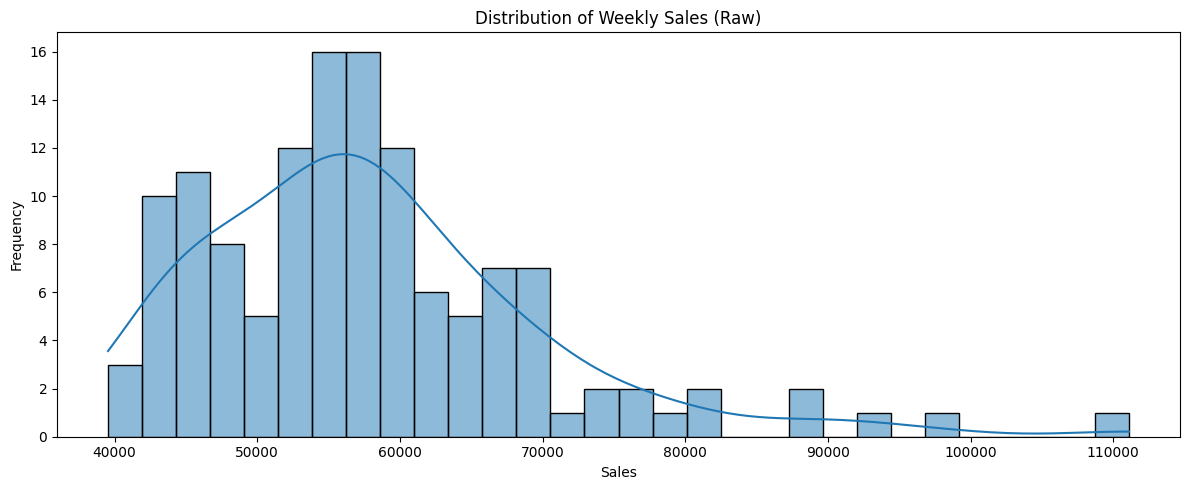

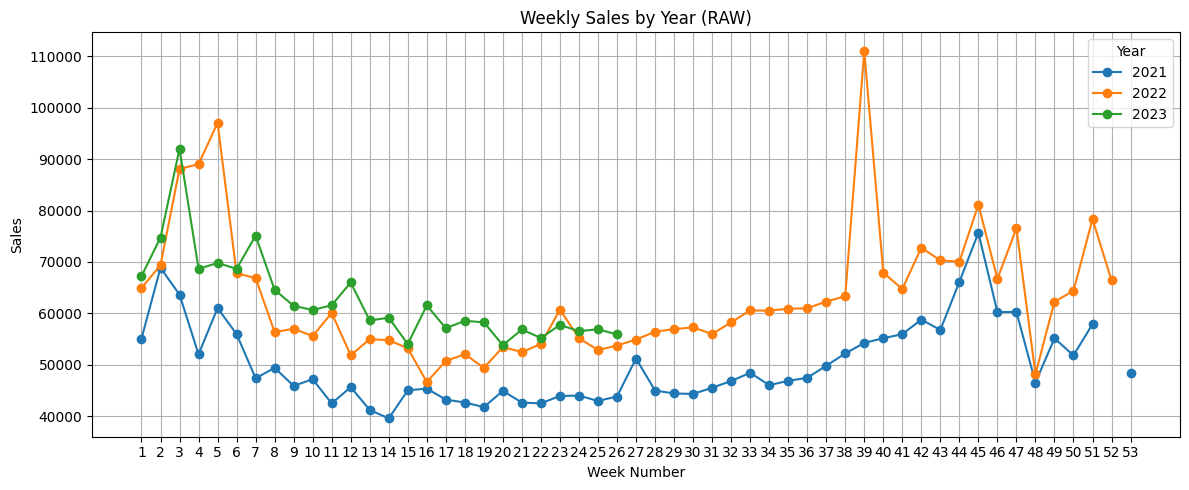

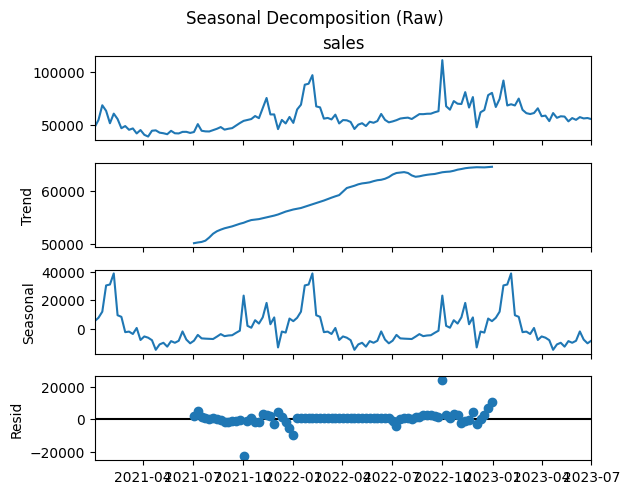

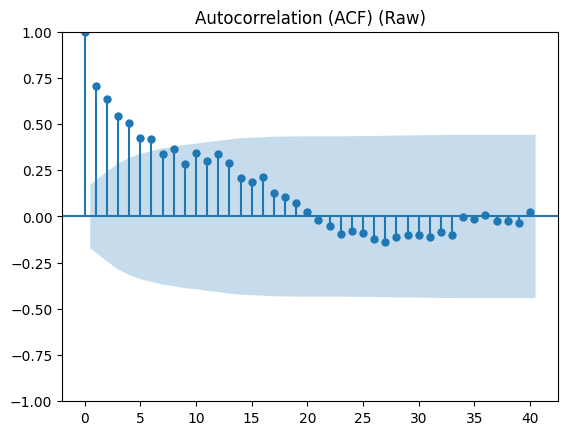

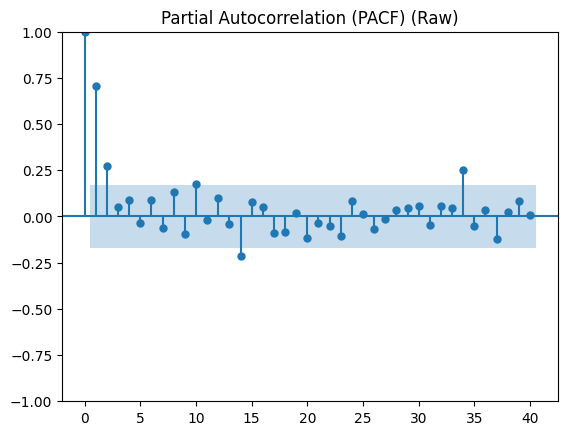

In [2]:
# Summary stats
print("\n📊 Summary statistics:")
print(df.describe())

# Distribution of weekly sales
plt.figure(figsize=(12, 5))
sns.histplot(df["sales"], bins=30, kde=True)
plt.title("Distribution of Weekly Sales (Raw)")
plt.xlabel("Sales")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

df_week = df.copy()
df_week["Year"] = df_week.index.year
df_week["Week"] = df_week.index.isocalendar().week

# Group by week and year
weekly_pivot = df_week.pivot_table(values="sales", index="Week", columns="Year")

weekly_pivot.plot(figsize=(12, 5), marker='o')
plt.title("Weekly Sales by Year (RAW)")
plt.xlabel("Week Number")
plt.ylabel("Sales")
plt.xticks(range(1, 54))  
plt.grid(True)
plt.tight_layout()
plt.show()

# Ensure weekly frequency
df_weekly = df.asfreq("W-SAT")

# Decompose (assume yearly seasonality: 52 weeks)
decomposition = seasonal_decompose(df_weekly["sales"], model="additive", period=52)

# Plot
decomposition.plot()
plt.suptitle("Seasonal Decomposition (Raw)", y=1.02)
plt.show()

plot_acf(df["sales"], lags=40)
plt.title("Autocorrelation (ACF) (Raw)")
plt.show()

plot_pacf(df["sales"], lags=40)
plt.title("Partial Autocorrelation (PACF) (Raw)")
plt.show()

In [3]:
# Prepare your data
df = df.sort_values("date").copy()
# Add more lagged features
for lag in range(1, 50):
    df[f"sales_lag_{lag}"] = df["sales"].shift(lag)

df = df.dropna()
X = df[[f"sales_lag_{lag}" for lag in range(1, 50)]]
y = df["sales"]
# Split while preserving time order
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lasso_cv = LassoCV(alphas=np.logspace(-2, 5, 10000), cv=5)
lasso_cv.fit(X_train, y_train)

ridge_cv = RidgeCV(alphas=np.logspace(-2, 5, 10000), cv=5)
ridge_cv.fit(X_train, y_train)

# Search over both alpha and l1_ratio
elastic_cv = ElasticNetCV(
    alphas=np.logspace(-2, 5, 100),
    l1_ratio=[.1, .5, .7, .9, .95, .99, 1],
    cv=5,
    max_iter=10000
)
elastic_cv.fit(X_train, y_train)

# Define the model
xgb_model = XGBRegressor(objective="reg:squarederror", random_state=42)

# Define parameter grid to search
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1],
    "reg_alpha": [0, 1, 10],   # L1
    "reg_lambda": [1, 5, 10],  # L2
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

# Define GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",  # or use "r2", "neg_mean_absolute_error"
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Run the search
grid_search.fit(X_train, y_train)

# Best model and parameters
print("Best XGB RMSE score:", -grid_search.best_score_)
print("Best XGB parameters:", grid_search.best_params_)
print("Best Lasso alpha:", lasso_cv.alpha_)
print("Best Ridge alpha:", ridge_cv.alpha_)
print("Best alpha:", elastic_cv.alpha_)
print("Best l1_ratio:", elastic_cv.l1_ratio_)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best XGB RMSE score: 11086.37877457575
Best XGB parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.8}
Best Lasso alpha: 100000.0
Best Ridge alpha: 100000.0
Best alpha: 100000.0
Best l1_ratio: 0.1


In [4]:
# Fit Lasso
lasso_model = Lasso(alpha=lasso_cv.alpha_)
lasso_model.fit(X_train, y_train)
lasso_preds = lasso_model.predict(X_test)
lasso_train_preds = lasso_model.predict(X_train)

# Fit Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)

# Fit Ridge Regression
ridge_model = Ridge(alpha=ridge_cv.alpha_)
ridge_model.fit(X_train, y_train)
ridge_preds = ridge_model.predict(X_test)

# Fit Elastic Net Regression
elastic_model = ElasticNet(alpha=elastic_cv.alpha_, l1_ratio=elastic_cv.l1_ratio_)
elastic_model.fit(X_train, y_train)
elastic_preds = elastic_model.predict(X_test)
elastic_train_preds = elastic_model.predict(X_train)

# Fit Random Forest 
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)
rf_train_preds = rf_model.predict(X_train)

# Fit XGBoost Model
xgb_model = grid_search.best_estimator_
xgb_preds = xgb_model.predict(X_test)
xgb_train_preds = xgb_model.predict(X_train)

# Fit Prophet Model
# Reformat for Prophet
df_prophet = df.reset_index()[["date", "sales"]].rename(columns={"date": "ds", "sales": "y"})
train_size = int(len(df_prophet) * 0.8)
train_prophet = df_prophet.iloc[:train_size]
test_prophet = df_prophet.iloc[train_size:]

prophet_model = Prophet()
prophet_model.fit(train_prophet)

# Generate future dataframe and forecast
future = prophet_model.make_future_dataframe(periods=len(test_prophet), freq="W-SAT")
forecast = prophet_model.predict(future)

# ✅ Set 'ds' as index once BEFORE any indexing operations
forecast = forecast.set_index("ds")

# Extract predictions matching test set
prophet_preds = forecast.loc[test_prophet["ds"], "yhat"].values

# Define feature names
feature_names = [f"sales_lag_{i}" for i in range(1, 50)]

# Create DataFrame to compare
coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Linear": lr_model.coef_,
    "Ridge": ridge_model.coef_,
    "Lasso": lasso_model.coef_
})

# Set Feature as index for cleaner display
coef_df.set_index("Feature", inplace=True)

# Combine actual values
combined_actuals = pd.concat([y_train, y_test])

# Combine predictions
combined_lasso_preds = pd.Series(
    np.concatenate([lasso_model.predict(X_train), lasso_model.predict(X_test)]),
    index=combined_actuals.index,
    name="Lasso_Prediction"
)

combined_linear_preds = pd.Series(
    np.concatenate([lr_model.predict(X_train), lr_model.predict(X_test)]),
    index=combined_actuals.index,
    name="Linear_Prediction"
)

# Combine all predictions
combined_ridge_preds = pd.Series(
    np.concatenate([ridge_model.predict(X_train), ridge_model.predict(X_test)]),
    index=combined_actuals.index,
    name="Ridge_Prediction"
)

# These lines are missing before get_metrics
lr_train_preds = lr_model.predict(X_train)
ridge_train_preds = ridge_model.predict(X_train)
elastic_train_preds = elastic_model.predict(X_train)
rf_train_preds = rf_model.predict(X_train)
xgb_train_preds = xgb_model.predict(X_train)

# For Prophet, y_train and y_test are split differently, so we extract them from df_prophet
y_prophet_train = train_prophet["y"].values
y_prophet_test = test_prophet["y"].values


# Define helper to compute metrics
def get_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    mbe = np.mean(y_pred - y_true)
    smape = 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))
    
    return {
        "RMSE": rmse,
        "MAE": mae,
        "MAPE": mape,
        "SMAPE": smape,
        "MBE": mbe,
        "R2": r2
    }
# Collect metrics
summary = pd.DataFrame({
    "Linear Train": get_metrics(y_train, lr_train_preds),
    "Linear Test": get_metrics(y_test, lr_preds),
    "Ridge Train": get_metrics(y_train, ridge_train_preds),
    "Ridge Test": get_metrics(y_test, ridge_preds),
    "Lasso Train": get_metrics(y_train, lasso_train_preds),
    "Lasso Test": get_metrics(y_test, lasso_preds),
    "ElasticNet Train": get_metrics(y_train, elastic_train_preds),
    "ElasticNet Test": get_metrics(y_test, elastic_preds),
    "RandomForest Train": get_metrics(y_train, rf_train_preds),
    "RandomForest Test": get_metrics(y_test, rf_preds),
    "XGBoost Train": get_metrics(y_train, xgb_train_preds),
    "XGBoost Test": get_metrics(y_test, xgb_preds),
    "Prophet Train": get_metrics(y_prophet_train, forecast.loc[train_prophet["ds"], "yhat"].values),
    "Prophet Test": get_metrics(y_prophet_test, prophet_preds)
}).T

# Transpose for readability
summary = summary.T
print(summary)

17:23:48 - cmdstanpy - INFO - Chain [1] start processing
17:23:48 - cmdstanpy - INFO - Chain [1] done processing


       Linear Train   Linear Test   Ridge Train    Ridge Test   Lasso Train  \
RMSE   2.907697e+07  8.575326e+08  2.907700e+07  8.547291e+08  2.931185e+07   
MAE    3.846425e+03  2.129201e+04  3.846351e+03  2.125611e+04  3.865948e+03   
MAPE   6.067808e+00  3.642605e+01  6.067183e+00  3.636470e+01  6.055937e+00   
SMAPE  6.007985e+00  3.787948e+01  6.007392e+00  3.780713e+01  5.999280e+00   
MBE   -4.063342e-11  2.791240e+02 -2.753670e-11  2.784522e+02  2.238756e-12   
R2     8.101350e-01 -9.641167e+01  8.101348e-01 -9.609320e+01  8.086013e-01   

         Lasso Test  ElasticNet Train  ElasticNet Test  RandomForest Train  \
RMSE   6.237517e+08      2.916890e+07     6.959046e+08        1.256175e+07   
MAE    1.820375e+04      3.861283e+03     1.919947e+04        2.194959e+03   
MAPE   3.113049e+01      6.062100e+00     3.285003e+01        3.196146e+00   
SMAPE  3.194635e+01      6.004297e+00     3.375148e+01        3.173158e+00   
MBE    1.524611e+02     -1.499967e-11     2.325487e+02  

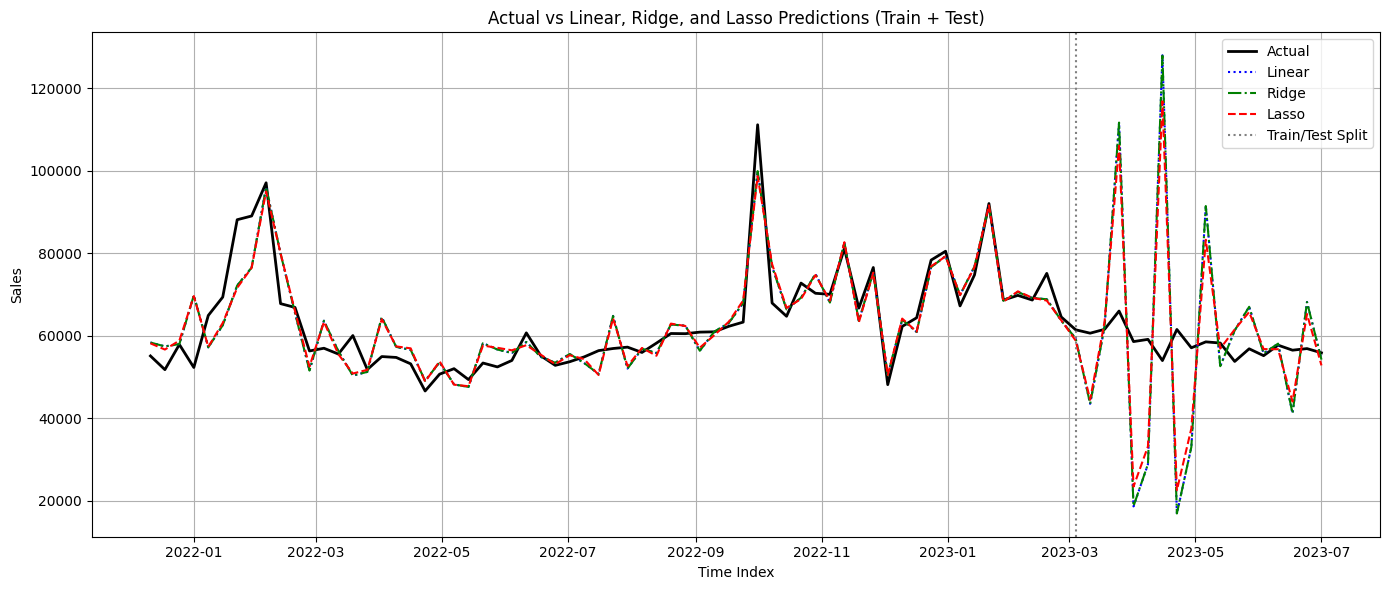

In [5]:
# Plot
plt.figure(figsize=(14, 6))
plt.plot(combined_actuals.index, combined_actuals.values, label="Actual", color="black", linewidth=2)
plt.plot(combined_linear_preds.index, combined_linear_preds.values, label="Linear", linestyle=":", color="blue")
plt.plot(combined_ridge_preds.index, combined_ridge_preds.values, label="Ridge", linestyle="-.", color="green")
plt.plot(combined_lasso_preds.index, combined_lasso_preds.values, label="Lasso", linestyle="--", color="red")
plt.axvline(x=y_train.index[-1], color="gray", linestyle=":", label="Train/Test Split")
plt.title("Actual vs Linear, Ridge, and Lasso Predictions (Train + Test)")
plt.xlabel("Time Index")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()